<a href="https://colab.research.google.com/github/MichelaMarini/NeuroSegment/blob/main/NeuroSegment_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Clone your GitHub repo
!git clone https://github.com/MichelaMarini/NeuroSegment.git
%cd NeuroSegment

Cloning into 'NeuroSegment'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 91 (delta 9), reused 66 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 57.74 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (9/9), done.


/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.11/dist-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attri

Processing: Dataset/images/C3-GRAY-DIV14_DMSO24h_FGF14_PanNavRabb_MAP2_160.tif


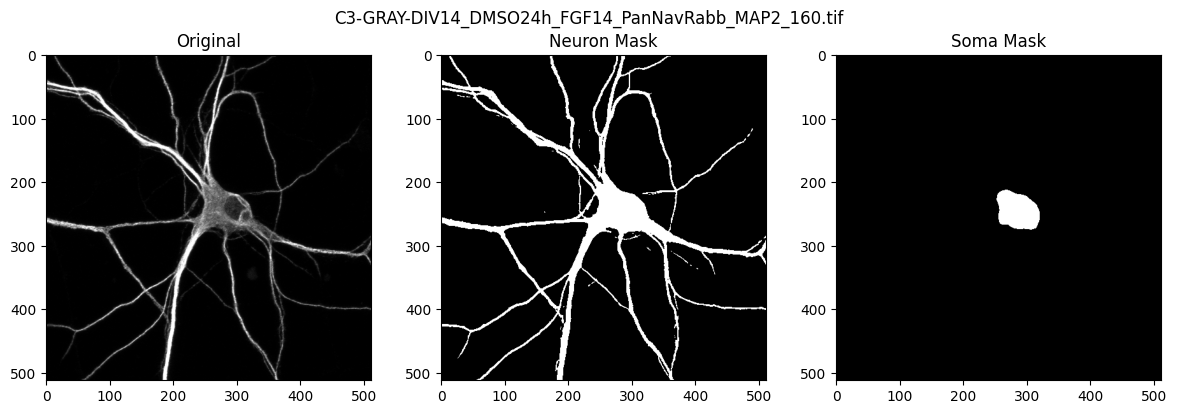

Processing: Dataset/images/C3-GRAY-DIV14_Trici24h_FGF14_PanNavRabb_MAP2_131.tif


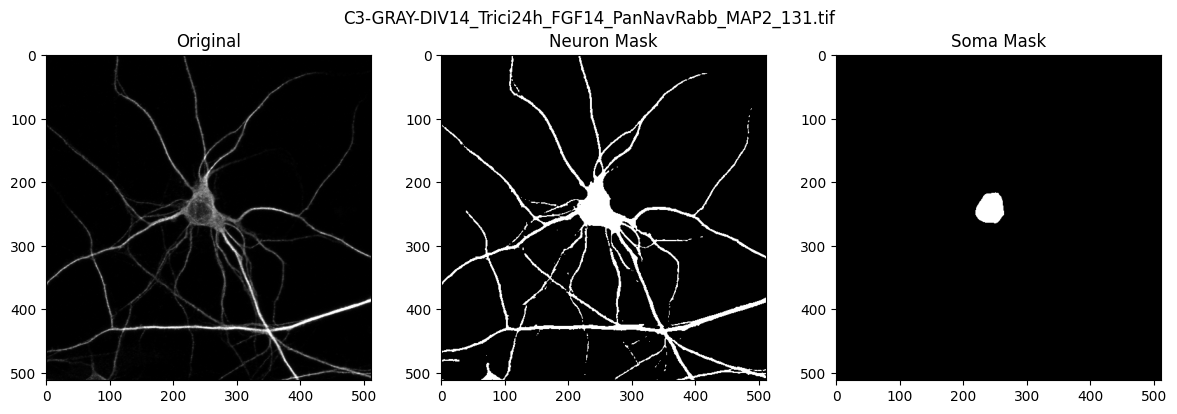

Processing: Dataset/images/C3-GRAY-DIV14_Trici24h_FGF14_PanNavRabb_MAP2_240.tif


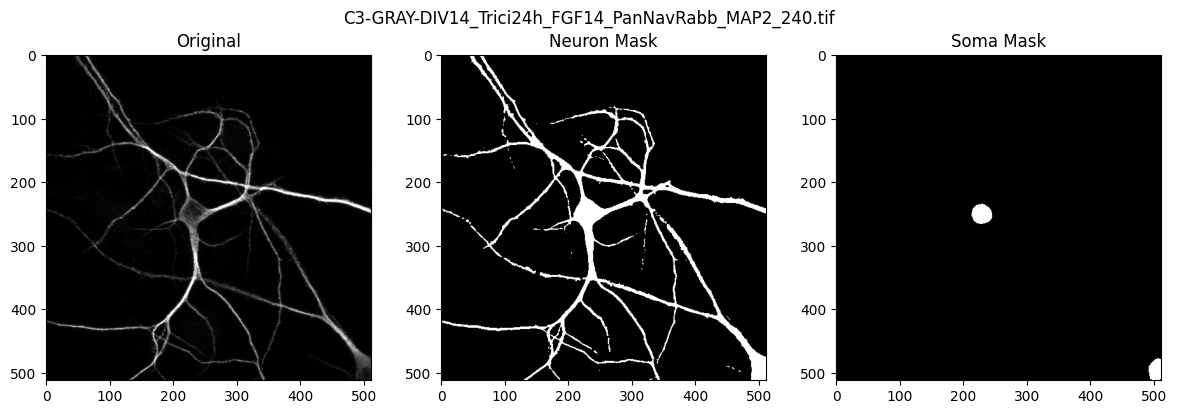

Processing: Dataset/images/C3-GRAY-MAX_DIV14_DMSO24h_FGF14_PanNavRabb_MAP2_22.tif


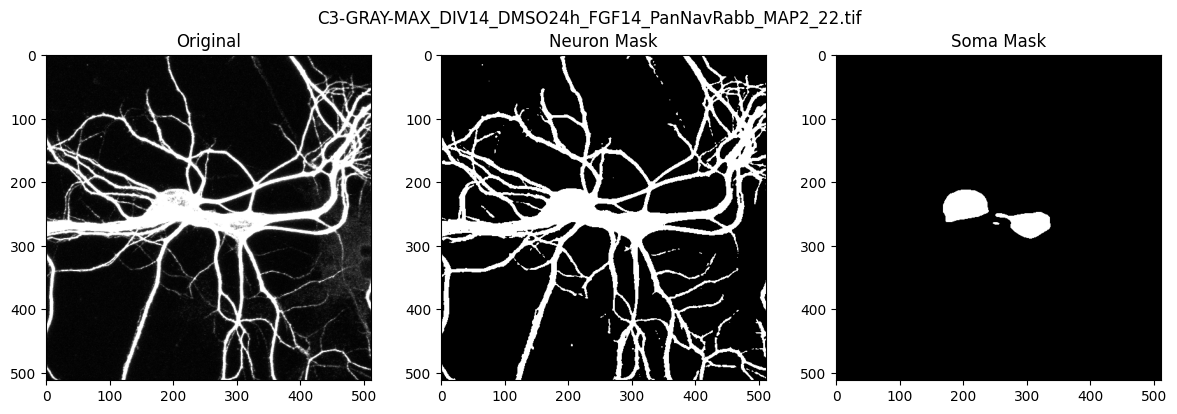

Processing: Dataset/images/C3-GRAY-MAX_DIV14_DMSO24h_FGF14_PanNavRabb_MAP2_23.tif


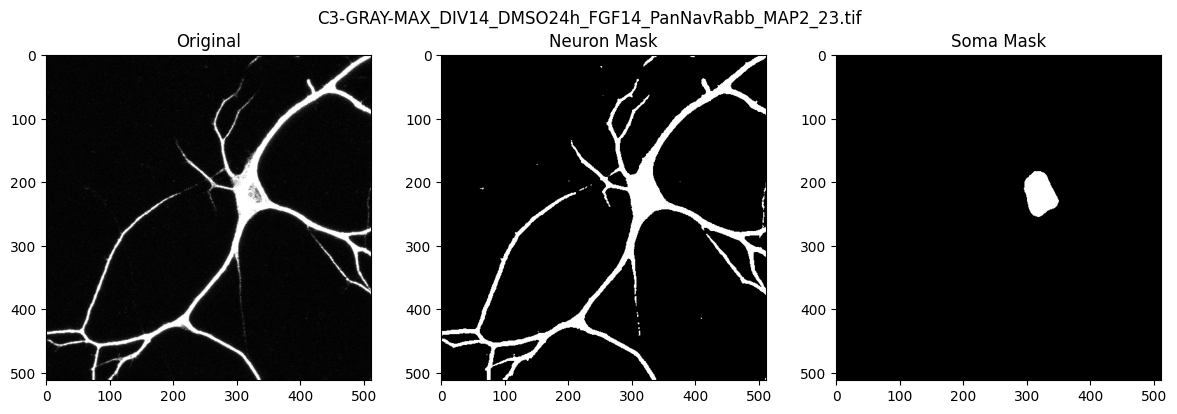

Processing: Dataset/images/C3-GRAY-MAX_DIV14_GSK24h_FGF14_PanNavRabb_MAP2_3.tif


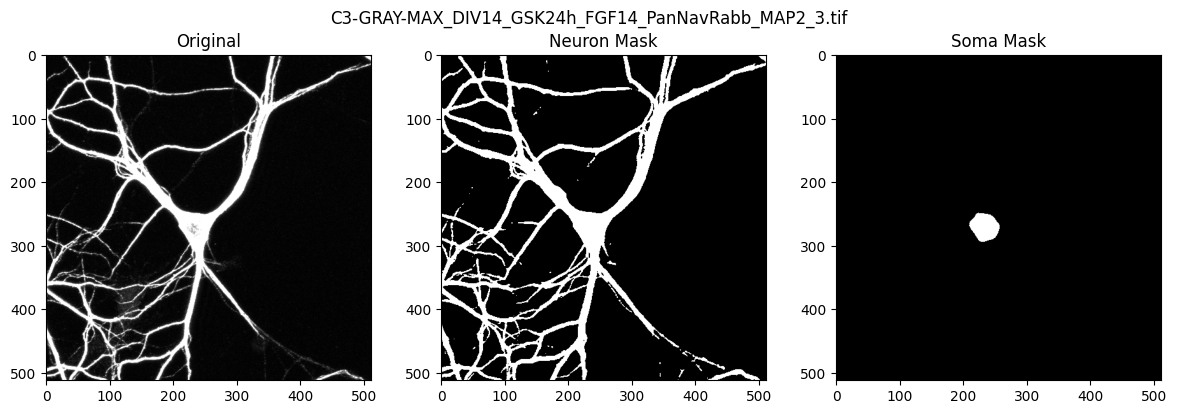

Processing: Dataset/images/C3-GRAY-MAX_DIV14_Trici24h_FGF14_PanNavRabb_MAP2_200.tif


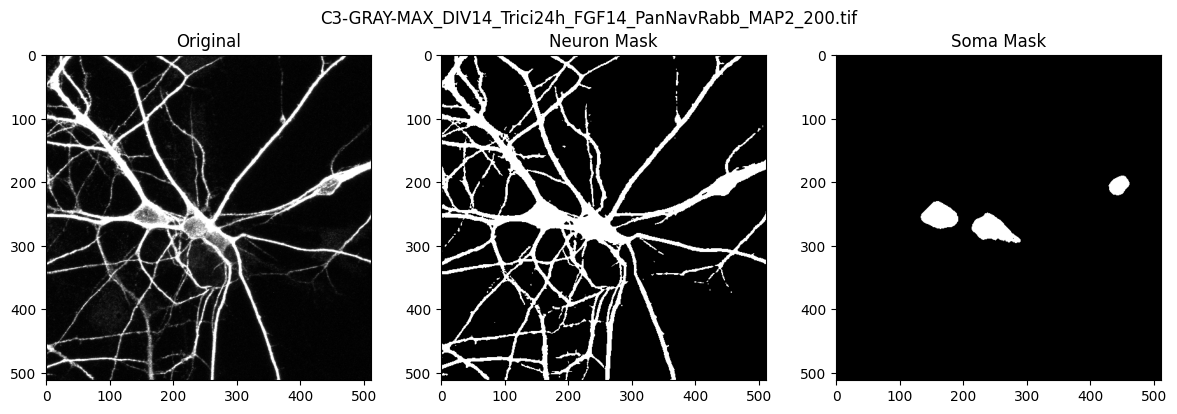

Processing: Dataset/images/C3-GRAY-MAX_DIV14_Trici24h_FGF14_PanNavRabb_MAP2_310.tif


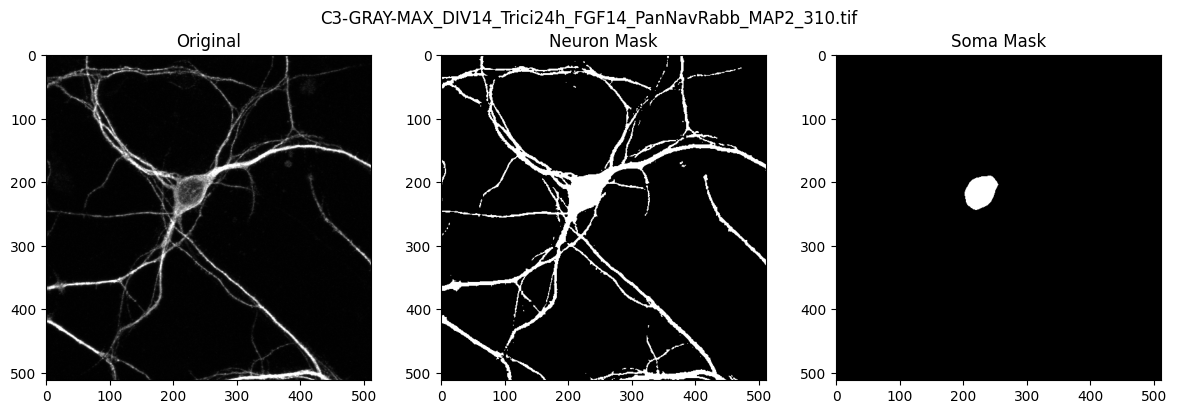

Processing: Dataset/images/C3-new_DIV14_GSK24h_FGF14_PanNavRabb_MAP2_250.tif


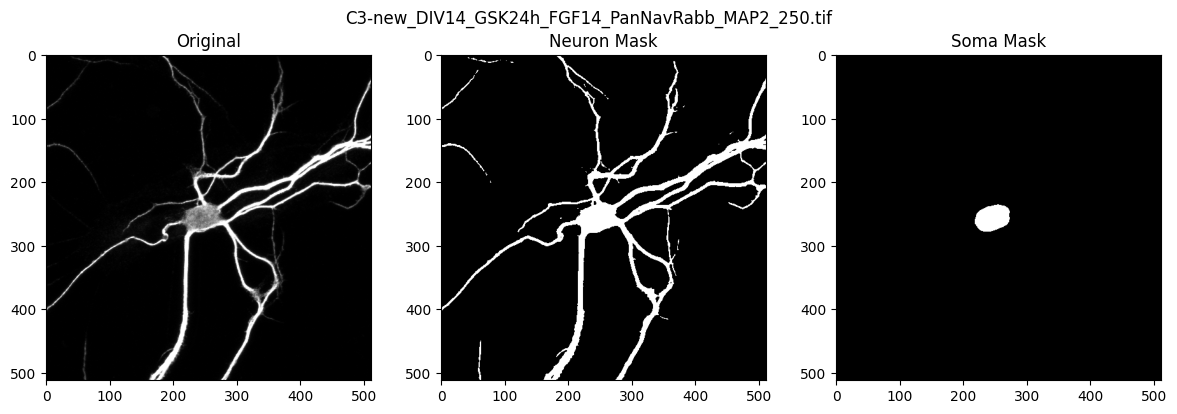

Processing: Dataset/images/C3-new_DIV14_Trici24h_FGF14_PanNavRabb_MAP2_70.tif


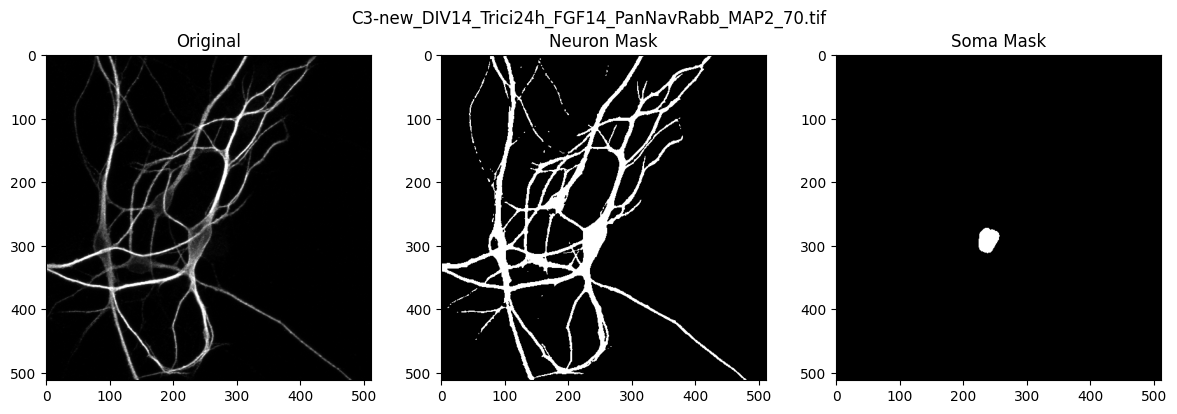

Processing: Dataset/images/MAX_24h_DMSO_FGF14_488_PanNav_568_MAP2_647_01_blue.tif


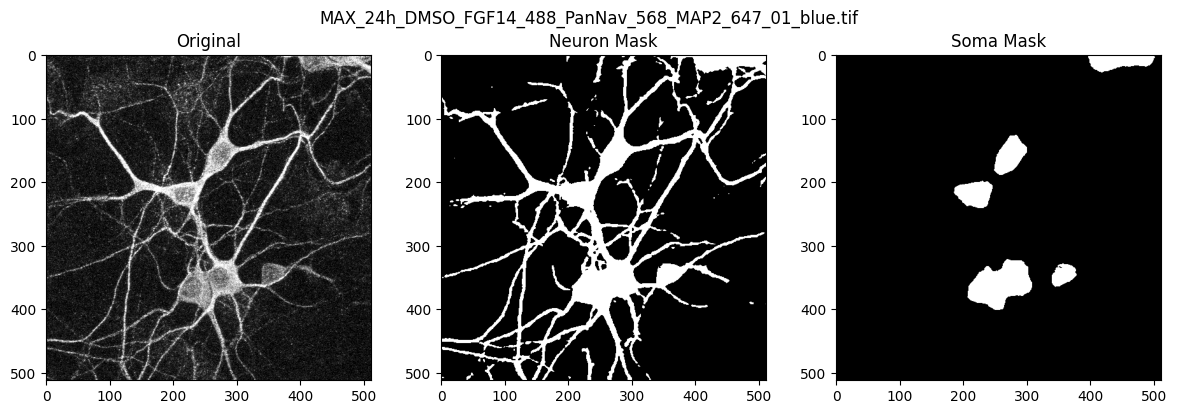

Processing: Dataset/images/MAX_24h_DMSO_FGF14_488_PanNav_568_MAP2_647_15_blue.tif


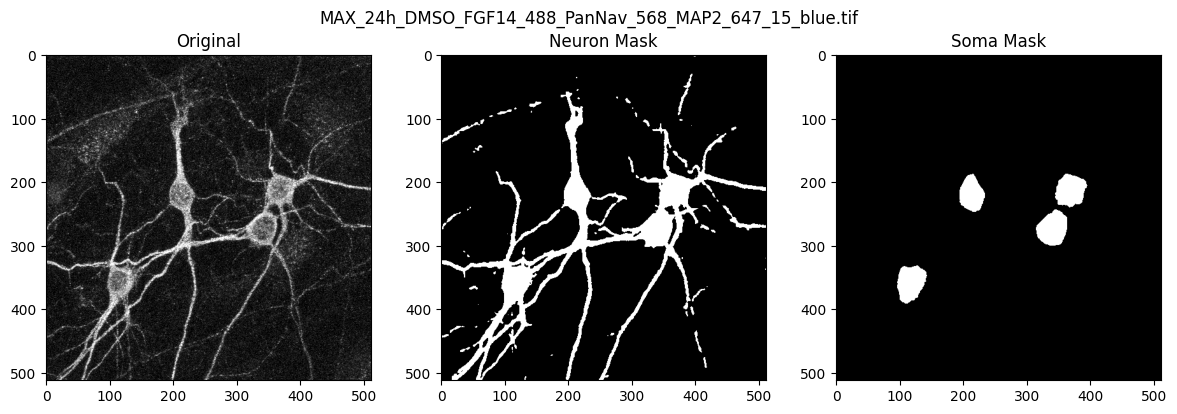

Processing: Dataset/images/MAX_24h_DMSO_FGF14_488_PanNav_568_MAP2_647_27_blue.tif


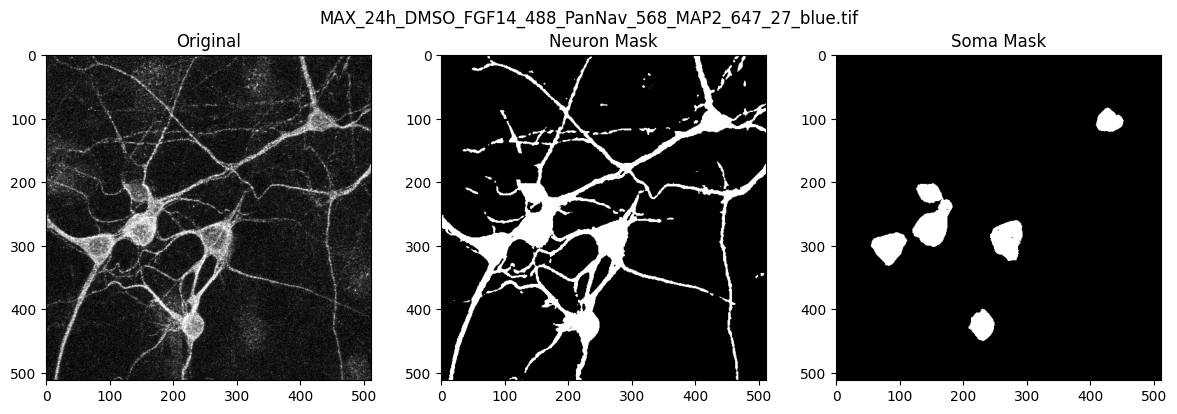

Processing: Dataset/images/MAX_DIV14_GSK24h_FGF14_PanNavRabb_MAP2_6_blue.tif


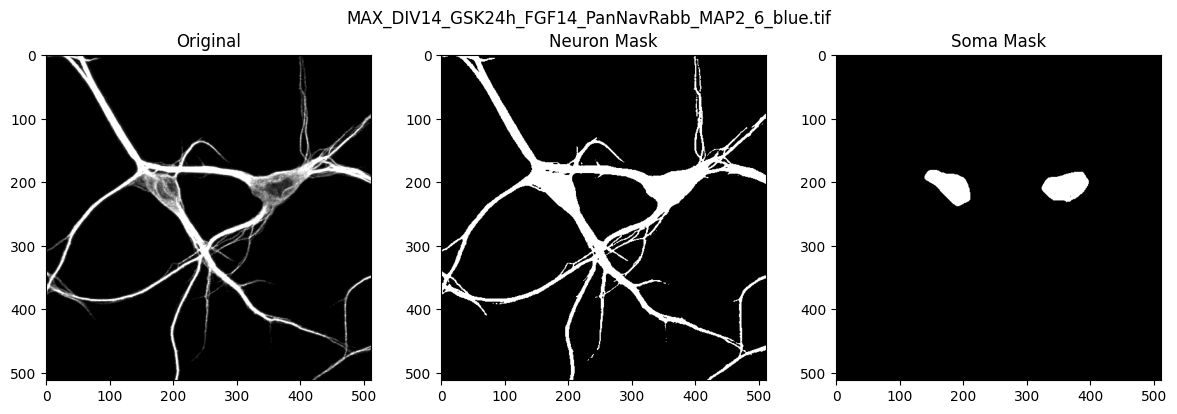

Processing: Dataset/images/MAX_DIV14_GSK24h_FGF14_PanNavRabb_MAP2_7_blue.tif


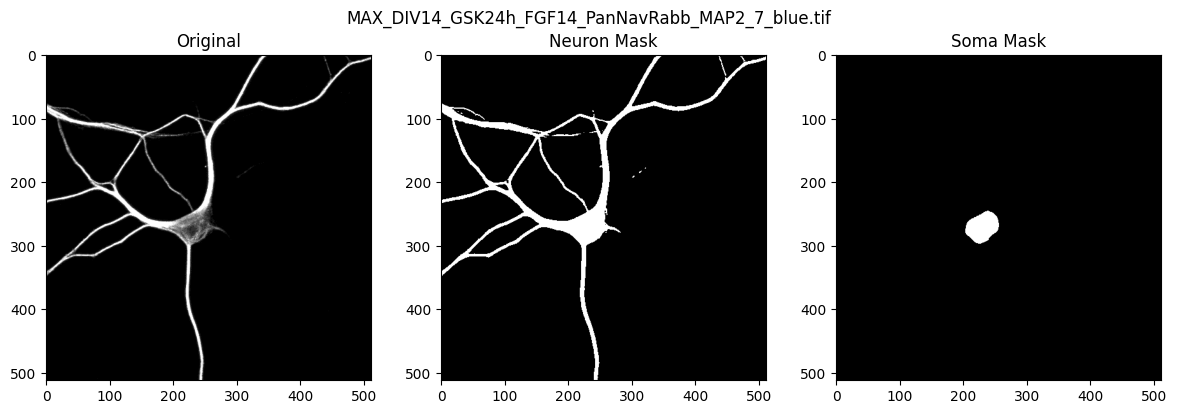

Processing: Dataset/images/MAX_DIV14_GSK24h_FGF14_PanNavRabb_MAP2_9_blue.tif


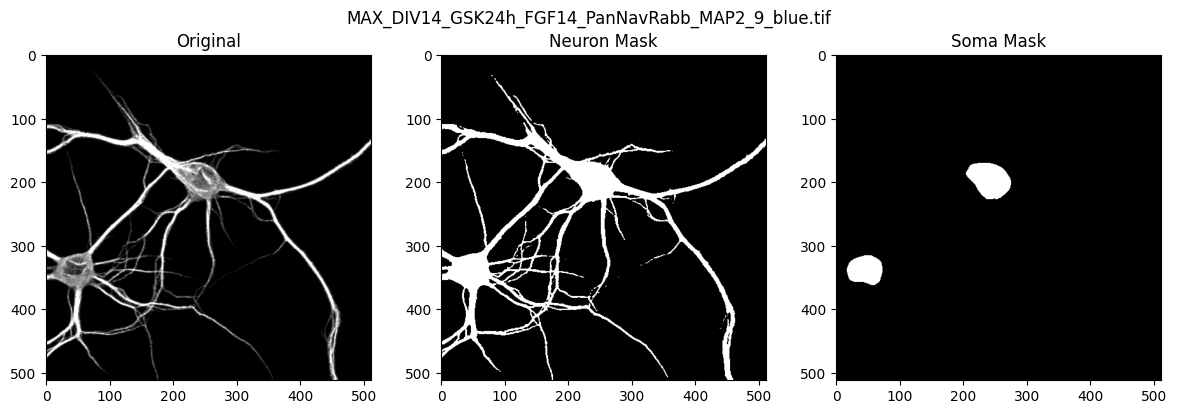

In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, disk
import torch.nn.functional as F
import Unet  # from repo

# ---------------------------------------
# 1. Load Trained U-Net Model
# ---------------------------------------
model = Unet.UNet(n_class=2)
checkpoint = torch.load("Model.pth", map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# ---------------------------------------
# 2. Get Image Paths
# ---------------------------------------
image_folder = "Dataset/images"
image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".tif")])

# ---------------------------------------
# 3. Process and Visualize All Images
# ---------------------------------------
for path in image_paths:
    print(f"Processing: {path}")

    slice_img = io.imread(path)

    # Prepare input tensor
    img = np.expand_dims(np.expand_dims(slice_img, axis=0), axis=0)
    img_tensor = torch.from_numpy(img).float()

    # Inference
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output).squeeze().numpy()  # shape: [2, H, W]

    # Post-processing
    soma_mask = binary_opening(output[1] > (0.9 * np.max(output[1])), disk(1))
    neuron_mask = output[0] > threshold_otsu(output[0])

    # Visualize
    plt.figure(figsize=(12, 4))
    plt.suptitle(os.path.basename(path), fontsize=12)

    plt.subplot(1, 3, 1)
    plt.imshow(slice_img, cmap='gray')
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(neuron_mask, cmap='gray')
    plt.title("Neuron Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(soma_mask, cmap='gray')
    plt.title("Soma Mask")

    plt.tight_layout()
    plt.show()